# Lab09

Synthesis: Development and application of plant models

In [1]:
using Cropbox

In [2]:
Cropbox.Interact.WebIO.setup(:ijulia)

WebIO._IJuliaInit()

## Garlic Model

### Ex 9.1

We examine a process-based model for garlic by [Hsiao et al. (2019)](https://doi.org/10.1093/aob/mcz060) and [Yun et al. (2022)](https://doi.org/10.3389/fpls.2022.783810) in this exercise. This model integrates most of the plant processes we’ve discussed so far in the class.

### Architecture

#### Ex 9.1.1

Inspect the model structure.

The [original model](https://doi.org/10.1093/aob/mcz060) was written in C++ and later [reimplemented](https://doi.org/10.3389/fpls.2022.783810) in Julia as a testbed for developing Cropbox framework.

In [3]:
using Garlic

The garlic model is named `Model` system in the `Garlic` package.

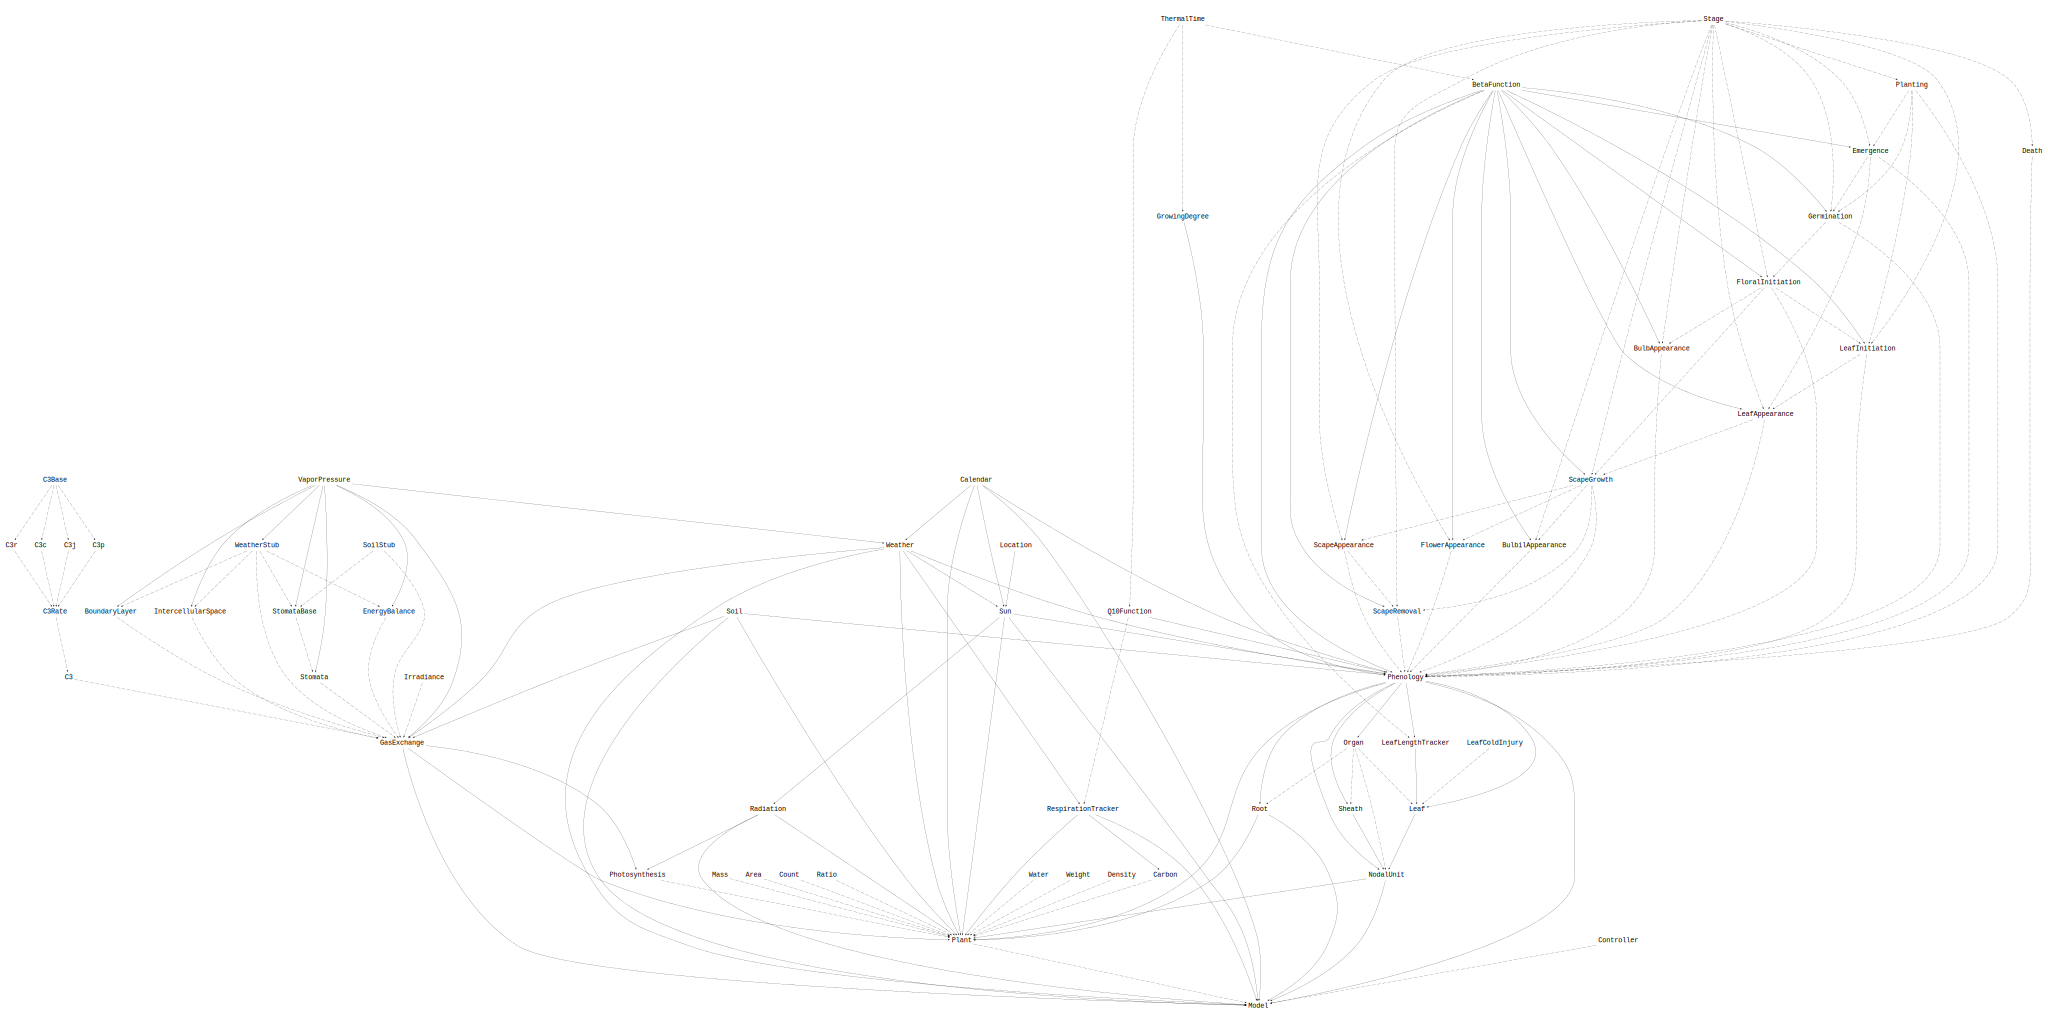

In [4]:
Cropbox.hierarchy(Garlic.Model; skipcontext = true)

While the model may look quite complex, the structure of the model shouldn't be too unfamiliar since the most parts of underlying concepts have been already covered throughout the quarter. For example, you can notice `GasExchange` system which is almost the same as the coupled gas-exchange model we covered in **Lab06**. `Phenology` system for tracking phenology consists of `BetaFunction` and `GrowingDegree` mixins we covered in **Lab07**. `Leaf` system for modeling leaf growth is not as simple as simple growth models we covered in **Lab02** and **Lab04**, but relying on the same principle.

If interested in the details how the model is implemented, feel free to read source code in the [Garlic.jl](https://github.com/cropbox/Garlic.jl) repository.

#### Ex 9.1.2

Identify plant processes represented in the model.

### Phenology

Let's take an in-depth look at the phenology (`Phenology`) part. There are systems representing each developmental stage of plant such as germination (`Germination`), canopy emergence (`Emergence`), leaf appearance (`LeafAppearance`), and so on. Many of them are driven by thermal time accumulation based on `BetaFunction` mixin, which is indicated by outgoing solid edges in the hierarchy diagram below.

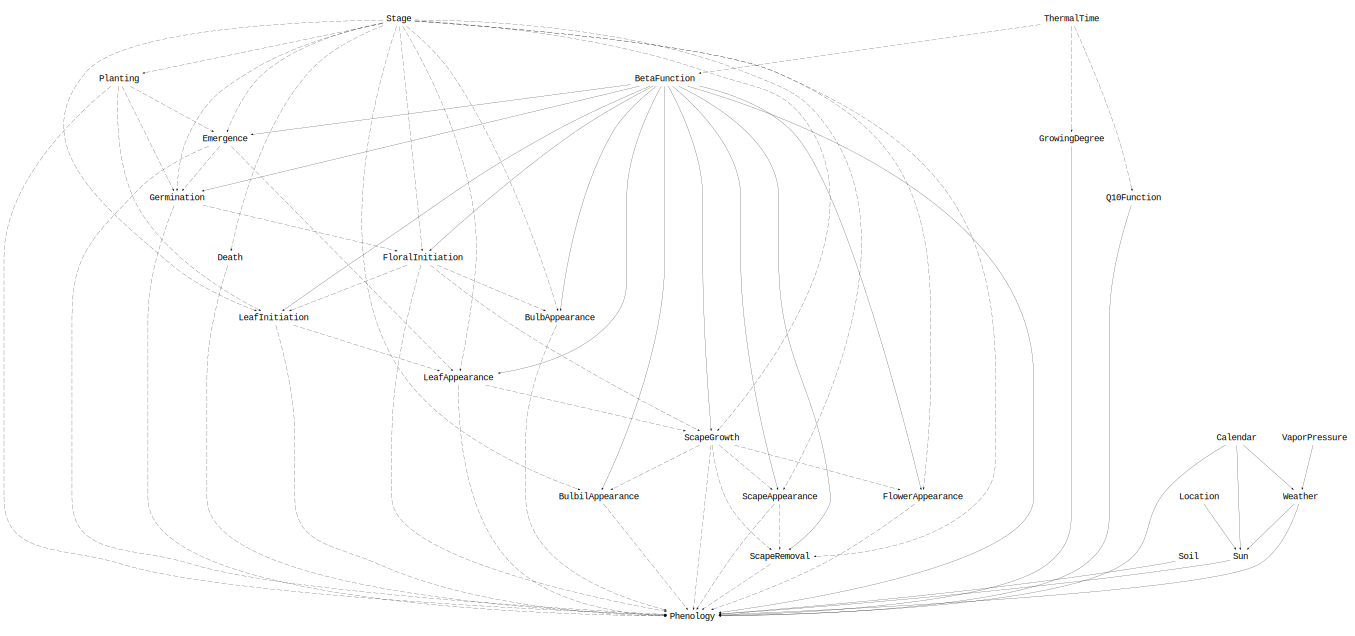

In [5]:
Cropbox.hierarchy(Garlic.Phenology; skipcontext = true)

Here, we choose `LeafAppearance` system to see its imeplementation, especially in comparison to phenology models we created last week. Cropbox provides `source()` function for inspecting model specification of an existing system.

In [6]:
Cropbox.source(Garlic.LeafAppearance)

quote
    #= /opt/julia/packages/Garlic/UXd59/src/phenology/leafappearance.jl:2 =#
    LTARa_max:maximum_phyllochron_asymptote => 0.4421 ~ preserve(u"d^-1", parameter)
    #= /opt/julia/packages/Garlic/UXd59/src/phenology/leafappearance.jl:3 =#
    _SDm => 117.7523 ~ preserve(u"d", parameter)
    #= /opt/julia/packages/Garlic/UXd59/src/phenology/leafappearance.jl:4 =#
    _k => 0.0256 ~ preserve(u"d^-1", parameter)
    #= /opt/julia/packages/Garlic/UXd59/src/phenology/leafappearance.jl:6 =#
    LTAR_max0(LTARa_max, SD, _SDm, _k):initial_maximum_phyllochron => begin
                #= /opt/julia/packages/Garlic/UXd59/src/phenology/leafappearance.jl:7 =#
                LTARa_max / (1 + exp(-k * (SD - SDm)))
            end ~ preserve(u"d^-1", parameter)
    #= /opt/julia/packages/Garlic/UXd59/src/phenology/leafappearance.jl:10 =#
    LTAR_max(LTAR_max0, LTARa_max, n = leaves_appeared, ng = leaves_generic):maximum_phyllochron => begin
                #= /opt/julia/packages/Garlic/UXd59/s

Well, it's not too legible due to autogenearated comments and no highligthing. Let's write it down by hand below. Some extra variables are added to the model we created last week, but the essentital concept remains the same. The leaf appearance rate per unit time (`r*β`) calculated using Beta function accumulates to `LTA` which is then added to the initial leaf count (`ILTA` = 1) to form the current number of leaves have appeared (`leaves_appeared`).

```julia
@system LeafAppearance(Stage, Emergence, LeafInitiation) begin
    ..

    LTA(r = LTAR_max, β = BF.ΔT): leaf_tip_appearance => r*β ~ accumulate(when = leaf_appearing)

    ILTA: initial_leaf_tip_appearance => 1            ~ track::int(when = emerged)
    leaves_appeared(ILTA, LTA)        => (ILTA + LTA) ~ track::int(round = :floor)
    
    ..
end
```

Then, how is the rate of Beta function `r`, that is the maximum leaf appearance rate (`LTAR_max`), determined? It used to be a parameter with a constant value in the previous model, but here we want to make it a little bit more advanced. We observed through field experiments that the stroage conditions (*i.e.* duration, temperature) of garlic seed bulbs could influence the leaf appearance rate once they were planted. Those seed bulbs with a longer storage term often ended up having leaves appeared much faster than the others. For modeling this process, we modified `LTAR_max` from a constant parameter to a dynamic variable adjusted by a logisitic function.

Aside from technical details, just note that the variable originally declared as `preserve(parameter)` now became `track` to accomodate a new process. Some related variables (*e.g.* `LTAR_max0`) and parameters (*e.g.* `LTARa_max`, `_SDm`, `_k`) were also added, but the overall structure of the model system remains largely the same.

```julia
@system LeafAppearance(Stage, Emergence, LeafInitiation) begin
    LTARa_max: maximum_phyllochron_asymptote => 0.4421   ~ preserve(parameter, u"d^-1")
    _SDm                                     => 117.7523 ~ preserve(parameter, u"d")
    _k                                       => 0.0256   ~ preserve(parameter, u"d^-1")

    LTAR_max0(LTARa_max, SD, _SDm, _k): initial_maximum_phyllochron => begin
        LTARa_max / (1 + exp(-k * (SD - SDm)))
    end ~ preserve(u"d^-1", parameter)

    LTAR_max(LTAR_max0, LTARa_max, n=leaves_appeared, ng=leaves_generic): maximum_phyllochron => begin
        n0 = 0
        r0 = LTAR_max0
        r1 = LTARa_max / 2
        r0 + (r1 - r0) * (clamp(n, n0, ng) - n0) / (ng - n0)
    end ~ track(u"d^-1")

    ..
end
```

The remaining variables mostly include `flag` variables such as `leaf_appearable` for checking if more leaves are ready to appear, `leaf_appeared` for checking if all leaves have appeared, and `leaf_appearing` for indicating more leaves are about to appear. These conditional variables are especially useful for keeping track of developmental stages in other parts of the phenolofy models to start/stop certain processes. In the example above, we can find some states are shared from other stages like canopy emergence (`emerged`) and leaf initiation (`leaves_initiated`). These external variables are accessible in `LeafAppearance` system because it contains `Emergence` and `LeafInitiation` as mixins.

```julia
@system LeafAppearance(Stage, Emergence, LeafInitiation) begin
    ..
    
    leaf_appearable(emerged) ~ flag
    leaf_appeared(leaves_appeared, leaves_initiated) => begin
        0 < leaves_initiated <= leaves_appeared
    end ~ flag
    leaf_appearing(leaf_appearable & !leaf_appeared) ~ flag
end
```

Now let's take out the phenology module as a standalone system for testing. Some shared dependencies like `Weather` have to be manually created.

In [7]:
@system PhenologyController(Garlic.Phenology, Controller) begin
    calendar(context)               ~ ::Calendar

    weather(context, calendar)      ~ ::Garlic.Weather
    sun(context, calendar, weather) ~ ::Garlic.Sun
    soil(context)                   ~ ::Garlic.Soil
end

PhenologyController

Also create a configuration using the dataset included in `Garlic.jl` package. The weather data comes from the year of 2010 collected from the site (ID = 185) called Gosan located at Jeju Island in South Korea. Planting date was November 1st.

In [8]:
pheno_config = @config(
    :Calendar  => :init          => ZonedDateTime(2010, 10, 1, tz"Asia/Seoul"),
    :Weather   => :store         => Garlic.loadwea(Garlic.datapath("Korea/185_2010.wea"), tz"Asia/Seoul"),
    :Phenology => :planting_date => ZonedDateTime(2010, 11, 1, tz"Asia/Seoul"),
)

Config for 3 systems:
  Calendar
    init = ZonedDateTime(2010, 10, 1, tz"Asia/Seoul")
  Weather
    store = 8760×10 DataFrame…
  Phenology
    planting_date = ZonedDateTime(2010, 11, 1, tz"Asia/Seoul")

Now we can plot the number of leaves appeared (`leaves_appeared`) along with the number of leaves initiated (`leaves_initiated`) simulated for about 10 months (300 days).

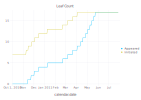

In [9]:
visualize(PhenologyController, "calendar.date", [:leaves_appeared, :leaves_initiated];
    config = pheno_config,
    stop = 300u"d",
    snap = 1u"d",
    title = "Leaf Count",
    names = ["Appeared", "Initiated"],
    kind = :line,
)

As we rely on Beta function, the interval between two leaves can be sometimes shorter, sometimes longer. Notably, the interval from January to February looks much longer and you can figure out the reason by looking at the temperature (`T`) plot.

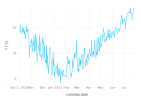

In [10]:
visualize(PhenologyController, "calendar.date", :T;
    config = pheno_config,
    stop = 300u"d",
    snap = 1u"d",
    kind = :line,
)

The garlic model also internally keeps track of major developmental stages with `development_phase` variable declared in `Symbol` type. The vegeatative stage (`vegetative`) began after planting in early November and remained until early April when leaf initiation stopped. All those leaves initiated during the vegetative stage would still continue growing and appear by mid May as we found in the previous plot. At this point, the plant development was already in the reproductive stage (`bulb_growth_before_scape_appearance`). The scape appeared in early June and its removal could be controlled via configuration, resulting into changes in carbon partitioning dynamics.

In [11]:
visualize(PhenologyController, "calendar.date", :development_phase;
    config = pheno_config,
    stop = 300u"d",
    snap = 1u"d",
    kind = :step,
)[] |> G.SVG(8G.inch, 4G.inch)

LoadError: UndefVarError: G not defined

Multiple stages of phenological development found in crop models may seemingly complex at first, then you would soon realize that many of them actually rely on the simple concept of thermal time accumulation. Perhaps it'd be more important to think about how to link multiple pieces into a single model.

### Photosynthesis

We already covered the structure of leaf-level coupled leaf-gas exchange model and its scaling to canopy-level in **Lab06**. `Garlic.jl` includes the almost same impelementation for calculating the total amount of carbon assimilation. `GasExchange` system implements the leaf-level gas-exchange and `Photosynthesis` system scales it up to the canopy-level.

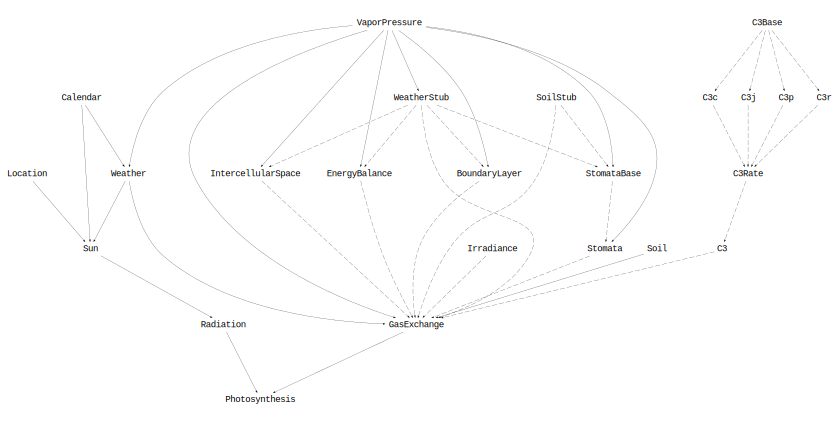

In [12]:
Cropbox.hierarchy(Garlic.Photosynthesis; skipcontext = true)

Remember that canopy-level scaling up was done in terms of the two-leaves approach via `Radiation` system for separating sunlit and shaded leaves. More details can be found on [De Pury and Farquhar (1997)](https://doi.org/10.1111/j.1365-3040.1997.00094.x). In our garlic model, we have two separate `GasExchange` systems for the two types of leaf and `Radiation` system calculates irradiance (`Q_sun`, `Q_sh`) and leaf area index (`LAI_sunlit`, `LAI_shaded`) for them. The total net photosynthesis rate at the canopy level (`A_net`) is determined by summing up two `A_net` from each gas-exchange systems in proportion to their respective `LAI`.

```julia
@system Photosynthesis begin
    ..
   
    radiation(context, sun, leaf_area_index) ~ ::Radiation

    sunlit_gasexchange(context, soil, weather, PPFD = Q_sun, LAI = LAI_sunlit) ~ ::GasExchange
    shaded_gasexchange(context, soil, weather, PPFD = Q_sh,  LAI = LAI_shaded) ~ ::GasExchange

    LAI_sunlit(radiation.sunlit_leaf_area_index): sunlit_leaf_area_index ~ track
    LAI_shaded(radiation.shaded_leaf_area_index): shaded_leaf_area_index ~ track

    Q_sun(radiation.irradiance_Q_sunlit): sunlit_irradiance ~ track(u"μmol/m^2/s")
    Q_sh(radiation.irradiance_Q_shaded):  shaded_irradiance ~ track(u"μmol/m^2/s")

    A_net(
        a = sunlit_gasexchange.A_net_total,
        b = shaded_gasexchange.A_net_total,
    ): net_CO2_umol_per_m2_s => a + b ~ track(u"μmol/m^2/s")

    ..
end
```

Let's make `Photosynthesis` as a standalone system for isolated testing.

In [13]:
@system PhotosynthesisController(Garlic.Photosynthesis, Garlic.Weight, Garlic.Water, Controller) begin
    calendar(context)                ~ ::Calendar

    weather(context, calendar)       ~ ::Garlic.Weather
    sun(context, calendar, weather)  ~ ::Garlic.Sun
    soil(context)                    ~ ::Garlic.Soil

    LAI(LAI0): leaf_area_index       ~ track(u"m^2/m^2")
    LAI0:      leaf_area_index_param ~ preserve(parameter, u"m^2/m^2")
    PD:        plant_density         ~ preserve(parameter, u"m^-2")
end

PhotosynthesisController

We basically use the same dataset as we used for phenology. Here we add parameters specific to photosynthesis such as leaf area index (`LAI`) and plant density (`PD`).

In [14]:
photo_config = @config(
    :Calendar                 => :init  => ZonedDateTime(2010, 10, 1, tz"Asia/Seoul"),
    :Weather                  => :store => Garlic.loadwea(Garlic.datapath("Korea/185_2010.wea"), tz"Asia/Seoul"),
    :PhotosynthesisController => (:LAI0 => 5, :PD => 55),
)

Config for 3 systems:
  Calendar
    init = ZonedDateTime(2010, 10, 1, tz"Asia/Seoul")
  Weather
    store = 8760×10 DataFrame…
  PhotosynthesisController
    LAI0 = 5
    PD   = 55

First, plot the net photosynthesis rate (`A_net`). It's not per leaf but per unit land area. By the way, even though we ran the model from October 1st, the actual result was mostly driven by `LAI` and `PD` parameters we supplied. We're just testing a subset of the model, not the full garlic model here.

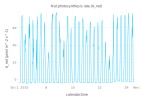

In [15]:
visualize(PhotosynthesisController, "calendar.time", :A_net;
    config = photo_config,
    stop = 30u"d",
    title = "Net photosynthesis rate (A_net)",
    kind = :line,
)   

Here are the net photosynthesis rates for sunlit and shaded leaves separated.

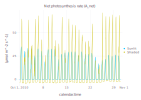

In [16]:
visualize(PhotosynthesisController, "calendar.time", [
        "sunlit_gasexchange.A_net_total",
        "shaded_gasexchange.A_net_total",
    ];
    config = photo_config,
    stop = 30u"d",
    title = "Net photosynthesis rate (A_net)",
    names = ["Sunlit", "Shaded"],
    kind = :line,
)   

Running the same simulation in a short period (3 days) shows diurnal patterns more clearly.

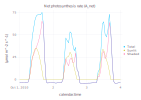

In [17]:
visualize(PhotosynthesisController, "calendar.time", [
        :A_net,
        "sunlit_gasexchange.A_net_total",
        "shaded_gasexchange.A_net_total",
    ];
    config = photo_config,
    stop = 3u"d",
    title = "Net photosynthesis rate (A_net)",
    names = ["Total", "Sunlit", "Shaded"],
    kind = :line,
)   

We can also split out LAI for the two leaves. Here we use the fixed value of 5 for the total LAI and the ratio between sunlit and shaded leaves dynamically change depending on the position of sun.

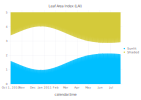

In [18]:
visualize(PhotosynthesisController, "calendar.time", [
        "radiation.LAI_sunlit",
        "radiation.LAI_shaded",
    ];
    config = photo_config,
    stop = 300u"d",
    title = "Leaf Area Index (LAI)",
    names = ["Sunlit", "Shaded"],
    kind = :line,
)   

For instance, in winter time, *e.g.* January 1st, the elevation of sun goes down and the ratio of direct sunlight reaching the sunlit leaf becomes relatively smaller.

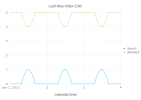

In [19]:
visualize(PhotosynthesisController, "calendar.time", [
        "radiation.LAI_sunlit",
        "radiation.LAI_shaded",
    ];
    config = (photo_config, :Calendar => :init  => ZonedDateTime(2011, 1, 1, tz"Asia/Seoul")),
    stop = 3u"d",
    title = "Leaf Area Index (LAI)",
    names = ["Sunlit", "Shaded"],
    kind = :line,
)   

Compare with summer time, *e.g.* July 1st, and see how the portion of sunlit leaf increases. The ratio also changes diurnally as sun rises and sets.

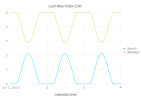

In [20]:
visualize(PhotosynthesisController, "calendar.time", [
        "radiation.LAI_sunlit",
        "radiation.LAI_shaded",
    ];
    config = (photo_config, :Calendar => :init  => ZonedDateTime(2011, 7, 1, tz"Asia/Seoul")),
    stop = 3u"d",
    title = "Leaf Area Index (LAI)",
    names = ["Sunlit", "Shaded"],
    kind = :line,
)   

We can also plot the amount of light received by the sunlit and shaded leaves. These are the irradiance values fed into two independent `GasExchange` instances.

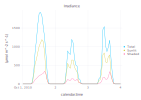

In [21]:
visualize(PhotosynthesisController, "calendar.time", ["radiation.sun.PARtot", :Q_sun, :Q_sh];
    config = photo_config,
    stop = 3u"d",
    title = "Irradiance",
    names = ["Total", "Sunlit", "Shaded"],
    kind = :line,
)   

### Biomass

#### Growth Rate

Do you remember we started modeling with simple growth functions like logistic and Gompertz in **Lab02**? At the time, we were trying to capture the shape of growth in a single curve, but now we know that the actual growth in terms of biomass isn't just the response of a single function, but rather shown up as an *emergent property* arising from multiple processes.

In [22]:
sim = simulate(Garlic.Model;
    config = Garlic.Examples.RCP.ND_RICCA_2014_field,
    stop = "calendar.count",
);

Progress: 100%[===========================] Time: 0:01:57 (17.97 ms/it)


Let's confirm this by running the garlic model. We use the dataset collected by Research Institute of Climate Change and Agriculture (RICCA) located at South Korea in 2014. The parameters were specifically calibrated for the local cultivar named Namdo (ND).

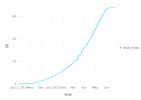

In [23]:
visualize(sim, :time, :total_mass; kind = :line)

This is the plot of total biomass simulated by the model for a season. It somewhat looks like the first half of an exponential curve or a smooth line generated by a Gompertz function. But as you know, this is not a curve directly generated by a single process.

The total biomass is actually a sum of biomass partitioned into individual organs. Among them, the biomass partitioned to the bulb decides the *yield* of garlics.

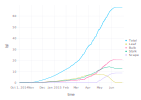

In [24]:
visualize(sim, :time, [:total_mass, :living_leaf_mass, :bulb_mass, :living_stalk_mass, :visible_scape_mass];
    kind  = :line,
    names = ["Total", "Leaf", "Bulb", "Stalk", "Scape"],
)

There are many factors influencing the calculation of total biomass and the total carbon assimilation rate per unit time (`total_carbon`) is one of them. This value is determined by the gross photosynthesis rate (`A_gross`) scaled up to a unit land area, as we saw in the gas-exchange part, and then adjusted for an individual canopy after taking account of respiration and conversion efficiency. For a single plant, this is the amount of change (increase or decrease) in biomass per unit time and the amount to be partitioned into multiple organs.

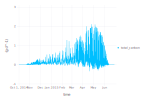

In [25]:
visualize(sim, :time, :total_carbon; kind = :line)

In **Lab02**, we first started with a constant growth rate, *e.g.* 0.03, for an exponential growth model, then soon realized that the growth rate should somehow decrease over time. In our garlic model, we don't have a specific parameter representing the growth rate, but instead we calculate one. If we divide the change of carbon at a specific time by the total biomass at the time, the result is the growth rate (`r`) that we discussed.

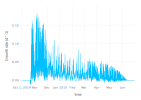

In [26]:
visualize(sim, :time, :(total_carbon / total_mass);
    kind = :line,
    ylab = "Growth rate",
    name = "",
    ylim = (-0.01, 0.2),
)

As expected, the growth rate has an overall decreasing pattern as a result of interaction between multiple processes responding to environmental conditions and developmental stages. Such discovering of an emergent property is one of primary reasons we want to make and use process-based models in our research.

#### Leaf Growth

The total amount of available carbon per unit time (`total_carbon`) we discussed above is determined by the carbon assimilation rate (`total_supply`).

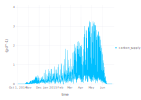

In [27]:
visualize(sim, :time, :carbon_supply; kind = :line)

And the carbon assimilation rate (`total_supply`) is directly related to the photosynthesis rate (`A_gross`).

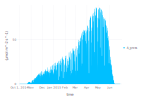

In [28]:
visualize(sim, :time, :A_gross; kind = :line)

And we need leaf area index (LAI) to convert the photosynthesis rate (`A_gross`) per leaf area to the photosynthesis rate per a unit land area. The shape of leaf area index actually looks quite similar to the photosynthesis rate above.

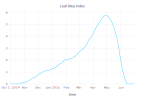

In [29]:
visualize(sim, :time, :LAI;
    title = "Leaf Area Index",
    name = "",
    kind = :line,
)

The leaf area index (LAI) is defined as the total leaf area divided by the land area. As the land area is fixed, the actual shape of LAI follows the total leaf area.

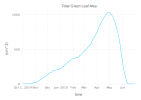

In [30]:
visualize(sim, :time, :green_leaf_area;
    title = "Total Green Leaf Area",
    name = "",
    kind = :line,
)

Then how we can calculate the total leaf area? There are many different approaches adopted by crop models. Many crop models, especially those relying on the concept of radiation use efficiency (RUE) instead of a more complicated gas-exchange model, often do not simulate the leaf area expansion directly, but rather derive it by multiplying biomass with a constant parameter of specific leaf area (SLA), which is defined as the total leaf area divided by total biomass. In our garlic model, however, we opted to model leaf growth as a separate process and simulate leaf expansion at an individual leaf-level.

In [31]:
plot_leaves(v;
    config = Garlic.Examples.RCP.ND_RICCA_2014_field,
    index = :time,
    target = [],
    stop = "calendar.count",
    snap = 1u"d",
    legend = "Rank",
    kw...
) = begin
    r = simulate(Garlic.Model;
        config, index, target, stop, snap,
        snatch = (D, s) -> begin
            for nu in s.NU
                D[end][Symbol(nu.rank')] = nu.leaf[v]'
            end
        end
    )
    n = ncol(r) - 1 - length(target)
    visualize(r, index, string.(1:n); legend, kw...)
end

plot_leaves (generic function with 1 method)

Let's take a look at how leaf area for individual leaves change over time. Each leaf (`Leaf`) enclosed in a nodal unit (`NodalUnit`) has its own developmental schedule determined by a shared phenology module. Leaf position (rank) also determines the total length of each leaf, which is eventually converted to the leaf area. The leaf area of first leaf can be accessed by `NU[1].leaf.area` variable from the model. `plot_leaves()` function collects such a variable from each leaf to make a plot.

In [32]:
plot_leaves(:green_area;
    title = "Green Leaf Area",
    kind = :line,
    ylim = (0, 150),
)

Progress: 100%[===========================] Time: 0:00:13 ( 2.03 ms/it)


LoadError: UndefVarError: ncol not defined

We can see 16 leaves in total grow in their own timing and vigor. They go through leaf area expansion, maturation, and senescence. The rank of leaf starts from 1 for the initially appeared leaf and counts on. Overall, leaves appeared later tend to grow larger and their stay green period dynamically changes depending on the time.

Leaf area is allometrically derived from leaf elongation, which is implemented as a thermal time accumulation using Beta function.

In [33]:
plot_leaves(:length;
    title = "Leaf Length",
    kind = :line,
    ylim = (0, 100),
)

Progress: 100%[===========================] Time: 0:00:12 ( 1.89 ms/it)


LoadError: UndefVarError: ncol not defined

The potential length of each leaf is determined by the total number of leaves at the time of initiation and the position (rank) of the newly formed leaf. You may refer to [Hsiao *et al.* 2019](https://doi.org/10.1093/aob/mcz060) for more details.

In [34]:
plot_leaves(:potential_length;
    title = "Potential Length",
    kind = :line,
    ylim = (0, 100),
)

Progress: 100%[===========================] Time: 0:00:11 ( 1.79 ms/it)


LoadError: UndefVarError: ncol not defined

The overall magnitude of potential length is primarily controlled by a parameter called the minimum length of longest leaf (`LM_min`). Let's take a look at how it affects leaf area expansion in comparison to the actual observation dataset. This is a simple example of sensitivity analysis.

In [35]:
obs = CSV.read(Garlic.datapath("Korea/ricca_2014_field.csv"), DataFrame) |> unitfy;

LoadError: UndefVarError: CSV not defined

In [36]:
p = visualize(obs, :measuring_date, :leaf_area;
    xlim = (DateTime(2014, 10, 1), DateTime(2015, 6, 30)),
    ylim = (0, 1200),
)
visualize!(p, Garlic.Model, :time, :green_leaf_area;
    config = Garlic.Examples.RCP.ND_RICCA_2014_field,
    stop = "calendar.count",
    snap = 1u"d",
    group = :Leaf => :LM_min => [60, 70, 80, 90, 100],
    kind = :line,
)

LoadError: UndefVarError: DateTime not defined

#### Ex 9.1.3

Identify state variables, parameters, and environmental variables of the model.

#### Ex 9.1.4

Run simulations using the weather and crop information available in Garlic package.

### Parameters

While we already saw how the model works above, let's give it a look again. Most of these parameters are described in [Hsiao *et al.* (2019)](https://doi.org/10.1093/aob/mcz060).

In [37]:
parameters(Garlic.Model; alias = true, recursive = true)

Config for 21 systems:
  Clock
    init = 0 hr
    step = 1 hr
  Context
  BetaFunction
    maximum_temperature = nothing
    minimum_temperature = 0 °C
    optimal_temperature = nothing
    beta                = 1
  GrowingDegree
    base_temperature    = nothing
    maximum_temperature = nothing
    optimal_temperature = nothing
  Q10Function
    Q10                 = 2
    optimal_temperature = nothing
  Phenology
    optimal_temperature           = 22.28 °C
    ceiling_temperature           = 34.23 °C
    planting_date                 = nothing
    emergence_date                = nothing
    maximum_emergence_rate        = 0.0876 d^-1
    emergence_optimal_temperature = 12.7 °C
    emergence_ceiling_temperature = 35.9 °C
    critical_photoperiod          = 12.5 hr
    storage_days                  = 100 d
    storage_temperature           = 5 °C
    initial_leaves_at_harvest     = 4
    maximum_leaf_initiation_rate  = 0.2 d^-1
    maximum_phyllochron_asymptote = 0.4421 d^-1
    (LeafAppearance) _SDm         = 117.752 d
    (LeafAppearance) _k           = 0.0256 d^-1
    initial_maximum_phyllochron   = missing
    leaves_generic                = 10
    scape_removal_date            = nothing
    flower_appearance_threshold   = 5.0
    scape_appearance_threshold    = 3.0
    bulbil_appearance_threshold   = 5.5
  Soil
  Location
    latitude  = 36°
    longitude = 128°
    altitude  = 20 m
  Sun
    transmissivity                                    = 0.5
    solar_constant                                    = 1370 W m^-2
    photosynthetic_active_radiation_conversion_factor = 4.6 μmol J^-1
  Calendar
    init = nothing
    last = nothing
  VaporPressure
    a = 0.611 kPa
    b = 17.502
    c = 240.97
  Weather
    store = nothing
    CO2   = 400 μmol mol^-1
  LeafLengthTracker
    beta = 1
  Leaf
    maximum_elongation_rate                   = 12 cm d^-1
    longevity                                 = 50 d
    cold_injury_factor1                       = -0.1 K^-1
    cold_injury_factor2                       = 1.6
    cold_injury_critical_temperature          = 0 °C
    (LeafColdInjury) _enable                  = true
    minimum_length_of_longest_leaf            = 60 cm
    length_to_width_ratio                     = 0.05
    area_ratio                                = 0.75
    stay_green                                = 3.5
    maximum_length_of_longest_leaf_adjustment = 0 cm^2
  Sheath
    growth_duration = 10 d
    longevity       = 50 d
  NodalUnit
    growth_duration = 10 d
    longevity       = 50 d
  RespirationTracker
    Q10                 = 2
    optimal_temperature = 20 °C
  Radiation
    leaf_angle        = ellipsoidal
    leaf_angle_factor = 0.7
    wave_band         = photosynthetically_active_radiation
    scattering        = 0.15
    clumping          = 1.0
    soil_reflectivity = 0.1
  GasExchange
    leaf_width                                   = 0.1 m
    stomatal_ratio                               = 1.0
    kinematic_viscosity_of_air_at_20             = 1.51e-5 m^2 s^-1
    thermal_diffusivity_of_air_at_20             = 2.15e-5 m^2 s^-1
    g0                                           = 0.096 mol bar^-1 m^-2 s^-1
    g1                                           = 6.824
    diffusivity_ratio_boundary_layer             = 1.37
    diffusivity_ratio_air                        = 1.6
    leaf_scattering                              = 0.15
    leaf_spectral_correction                     = 0.15
    leaf_thermal_emissivity                      = 0.97
    latent_heat_of_vaporization_at_25            = 44 kJ mol^-1
    specific_heat_of_air                         = 29.3 J K^-1 mol^-1
    absorption_coefficient                       = 0.5
    base_temperature                             = 25 °C
    rubisco_constant_for_co2_at_25               = 404.9 μbar
    activation_energy_for_co2                    = 79.43 kJ mol^-1
    rubisco_constant_for_o2_at_25                = 278.4 mbar
    activation_energy_for_o2    

`Garlic` package also provides a few sample configurations in its `Examples` module for testing. We'll pick up `RCP.ND_RICCA_2014_field` which is a configuration for the experiment conducted in 2014 with a cultivar named Namdo (ND) in the field located at the Research Institute of Climate Change and Agriculture (RICCA) in Jeju, Korea.

In [38]:
config = Garlic.Examples.RCP.ND_RICCA_2014_field

Config for 7 systems:
  Phenology
    optimal_temperature           = 22.28
    ceiling_temperature           = 34.23
    critical_photoperiod          = 12
    maximum_leaf_initiation_rate  = 0.1003
    storage_temperature           = 8
    maximum_phyllochron_asymptote = 0.4421
    leaves_generic                = 10
    initial_leaves_at_harvest     = 6
    scape_appearance_threshold    = 3.0
    planting_date                 = ZonedDateTime(2014, 10, 8, tz"Asia/Seoul")
    scape_removal_date            = nothing
    harvest_date                  = ZonedDateTime(2015, 6, 19, tz"Asia/Seoul")
    storage_days                  = 100
  Leaf
    maximum_elongation_rate        = 5.0
    minimum_length_of_longest_leaf = 90.0
    stay_green                     = 1.5
  Carbon
    maintenance_respiration_coefficient = 0.015
    synthesis_efficiency                = 0.75
    partitioning_table                  = [0.0 0.0 … 0.0 0.0; 0.35 0.3 … 0.0 0.1; … ; 0.05 0.0 … 0.0 0.95; 0.0 0.0 … 0.0 0.0]
  Plant
    initial_planting_density = 55.5
  Location
    latitude  = 33.4684
    longitude = 126.518
  Weather
    store = 8760×10 DataFrame…
  Calendar
    init = ZonedDateTime(2014, 10, 1, tz"Asia/Seoul")
    last = ZonedDateTime(2015, 6, 30, tz"Asia/Seoul")

### Simulation

We'll rely on `simulate()` function as we always did, but with a slightly different syntax. Let's take a look at the arguments one by one.

The number of model updates for stop condition (`stop`) is provided by `count` variable in the `calendar` system and is determined by start (`calendar.init`) and end date (`calendar.last`) specified in the configuration.

In [39]:
stop = "calendar.count"

"calendar.count"

For target variables (`target`) included in the output, not only all variables exposed in the `Model` system (`"*"`), we also want to extract other variables from the nested phenology system (`"pheno.*"`).

In [40]:
target = ["*", "pheno.*"]

2-element Vector{String}:
 "*"
 "pheno.*"

`snap` determines how often a *snapshot* of the model should be captured and recorded in the output. Since the default time unit (`1u"hr"`) is too fine-grained in the scale of garlic growth which takes several months, we want to write down our results in a daily unit (`1u"d"`) instead for performance reason.

In [41]:
snap = 1u"d"

1 d

After setting up all required arguments, running simulation is simple as `simulate()` for other models. It will just take a while to run for the first time as we already got used to do with how Julia works.

In [42]:
sim = simulate(Garlic.Model; config, stop, target, snap)

Progress: 100%[===========================] Time: 0:00:27 ( 4.15 ms/it)


273×185 DataFrame
 Row │ time                       initial_leaf_ratio  potential_leaf_area_incr ⋯
     │ ZonedDat…                  Float64             Quantity…                ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 2014-10-01T00:00:00+09:00               0.126                      0.0  ⋯
   2 │ 2014-10-02T00:00:00+09:00               0.126                      0.0
   3 │ 2014-10-03T00:00:00+09:00               0.126                      0.0
   4 │ 2014-10-04T00:00:00+09:00               0.126                      0.0
   5 │ 2014-10-05T00:00:00+09:00               0.126                      0.0  ⋯
   6 │ 2014-10-06T00:00:00+09:00               0.126                      0.0
   7 │ 2014-10-07T00:00:00+09:00               0.126                      0.0
   8 │ 2014-10-08T00:00:00+09:00               0.126                      0.0
   9 │ 2014-10-09T00:00:00+09:00               0.126                      0.0  ⋯
  10 │ 2014-10-10T00:00:00+09:00               0.126                      0.0
  11 │ 2014-10-11T00:00:00+09:00               0.126                      0.0
  ⋮  │             ⋮                      ⋮                        ⋮           ⋱
 264 │ 2015-06-21T00:00:00+09:00               0.126                      0.0
 265 │ 2015-06-22T00:00:00+09:00               0.126                      0.0  ⋯
 266 │ 2015-06-23T00:00:00+09:00               0.126                      0.0
 267 │ 2015-06-24T00:00:00+09:00               0.126                      0.0
 268 │ 2015-06-25T00:00:00+09:00               0.126                      0.0
 269 │ 2015-06-26T00:00:00+09:00               0.126                      0.0  ⋯
 270 │ 2015-06-27T00:00:00+09:00               0.126                      0.0
 271 │ 2015-06-28T00:00:00+09:00               0.126                      0.0
 272 │ 2015-06-29T00:00:00+09:00               0.126                      0.0
 273 │ 2015-06-30T00:00:00+09:00               0.126                      0.0  ⋯
                                                183 columns and 252 rows omitted

### Output

The result contains lots of variables. Here is a graph of simulated green leaf area over time.

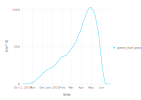

In [43]:
visualize(sim, :time, :green_leaf_area; kind = :line)

For comparison, we'll load up an observation dataset included in the package.

In [44]:
using CSV
using DataFrames

obs = CSV.read(Garlic.datapath("Korea/ricca_2014_field.csv"), DataFrame) |> unitfy

160×23 DataFrame
 Row │ cultivar  planting_date  measuring_date  plant_height  bulb_diameter  b ⋯
     │ String3   Date           Date            Quantity…     Quantity…      Q ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ ND        2014-10-08     2015-01-16           61.4 cm        17.8 mm    ⋯
   2 │ ND        2014-10-08     2015-01-16           53.6 cm        22.1 mm 
   3 │ ND        2014-10-08     2015-01-16           58.2 cm        18.8 mm 
   4 │ ND        2014-10-08     2015-01-16           60.2 cm        19.0 mm 
   5 │ ND        2014-10-08     2015-01-16           56.1 cm        19.9 mm    ⋯
   6 │ ND        2014-10-08     2015-01-16           63.3 cm        24.9 mm 
   7 │ ND        2014-10-08     2015-01-16           62.6 cm        21.2 mm 
   8 │ ND        2014-10-08     2015-01-16           57.5 cm        19.7 mm 
   9 │ ND        2014-10-08     2015-01-16           59.5 cm        22.3 mm    ⋯
  10 │ ND        2014-10-08     2015-01-16           59.2 cm        17.6 mm 
  11 │ ND        2014-10-08     2015-01-23           64.4 cm        24.2 mm 
  ⋮  │    ⋮            ⋮              ⋮              ⋮              ⋮          ⋱
 151 │ ND        2014-10-08     2015-06-04           85.2 cm        60.6 mm
 152 │ ND        2014-10-08     2015-06-04           77.1 cm        62.7 mm    ⋯
 153 │ ND        2014-10-08     2015-06-04           94.1 cm        56.2 mm
 154 │ ND        2014-10-08     2015-06-04          112.4 cm        58.1 mm
 155 │ ND        2014-10-08     2015-06-04           81.2 cm        51.0 mm
 156 │ ND        2014-10-08     2015-06-04           87.8 cm        59.9 mm    ⋯
 157 │ ND        2014-10-08     2015-06-04          106.2 cm        52.2 mm
 158 │ ND        2014-10-08     2015-06-04           94.8 cm        64.0 mm
 159 │ ND        2014-10-08     2015-06-04           78.2 cm        56.4 mm
 160 │ ND        2014-10-08     2015-06-04          102.8 cm        58.0 mm    ⋯
                                                 18 columns and 139 rows omitted

Here is a plot of the green leaf area with observation.

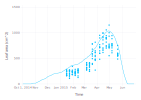

In [45]:
p = visualize(sim, :time, :green_leaf_area;
    kind = :line,
    ylim = (0, 1500),
    xlab = "Time",
    ylab = "Leaf area",
    name = "",
)
visualize!(p, obs, :measuring_date, :leaf_area;
    name  = "",
    color = 1,
)

Similary, we can make other plots. Here is a plot of biomass accumulated for each organ.

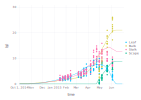

In [46]:
p = visualize(sim, :time, [:living_leaf_mass, :bulb_mass, :living_stalk_mass, :visible_scape_mass];
    kind  = :line,
    ylim  = (0, 30),
    names = ["Leaf", "Bulb", "Stalk", "Scape"],
)
visualize!(p, obs, :measuring_date, [:leaf_dry_weight, :bulb_dry_weight, :stem_dry_weight, :scape_dry_weight];
    colors = [1, 2, 3, 4],
    names  = [],
)

Here is a plot of leaf count per leaf development stage with observation.

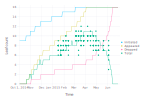

In [47]:
p = visualize(sim, :time, :leaves_initiated;
    kind = :line,
    ylim = (0, 16),
    xlab = "Time",
    ylab = "Leaf count",
    name = "Initiated",
)
visualize!(p, sim, :time, [:leaves_appeared, :leaves_dropped, :leaves_fresh];
    kind  = :line,
    names = ["Appeared", "Dropped", "Total"],
)
visualize!(p, obs, :measuring_date, :leaf_count;
    name  = "",
    color = 4,
)

#### Ex 9.1.5

Perform sensitivity analyses of model parameters on key state variables.

### Sensitivity Analysis

We can conduct a simple sentivity analysis by running the model for multiple times with a slightly different value of parameter.

In [48]:
using Dates

xlim = (DateTime(2014,10,1), DateTime(2015,6,30))

(DateTime("2014-10-01T00:00:00"), DateTime("2015-06-30T00:00:00"))

#### Leaf Tip Appearance Rate (asymptote)

In [49]:
config[:Phenology][:maximum_phyllochron_asymptote]

0.4421

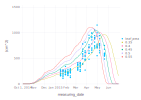

In [50]:
p = visualize(obs, :measuring_date, :leaf_area;
    xlim,
    ylim = (0,1500),
)
visualize!(p, Garlic.Model, :time, :green_leaf_area;
    config, stop, snap,
    group = :Phenology => :LTARa_max => [0.35, 0.4, 0.45, 0.5, 0.55],
    kind  = :line,
)

#### Initial Leaves at Harvest

In [51]:
config[:Phenology][:initial_leaves_at_harvest]

6

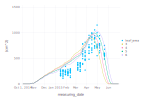

In [52]:
p = visualize(obs, :measuring_date, :leaf_area;
    xlim,
    ylim = (0,1500),
)
visualize!(p, Garlic.Model, :time, :green_leaf_area;
    config, stop, snap,
    group = :Phenology => :ILN => [3, 4, 5, 6],
    kind  = :line,
)

#### Critical Photoperiod

In [53]:
config[:Phenology][:critical_photoperiod]

12

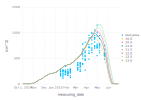

In [54]:
p = visualize(obs, :measuring_date, :leaf_area;
    xlim,
    ylim = (0,1500),
)
visualize!(p, Garlic.Model, :time, :green_leaf_area;
    config, stop, snap,
    group = :Phenology => :critPPD => [10, 10.5, 11, 11.5, 12, 12.5, 13],
    kind  = :line,
)

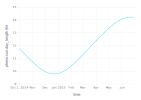

In [55]:
visualize(Garlic.Model, :time, "pheno.sun.day_length";
    config, stop, snap,
    kind = :line,
)

#### Leaf Initiation Rate

In [56]:
config[:Phenology][:maximum_leaf_initiation_rate]

0.1003

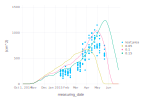

In [57]:
p = visualize(obs, :measuring_date, :leaf_area;
    xlim,
    ylim = (0,1500),
)
visualize!(p, Garlic.Model, :time, :green_leaf_area;
    config, stop, snap,
    group = :Phenology => :LIR_max => [0.05, 0.1, 0.15],
    kind  = :line,
)

#### Storage Temperature

In [58]:
config[:Phenology][:storage_temperature]

8

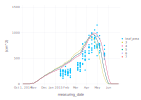

In [59]:
p = visualize(obs, :measuring_date, :leaf_area;
    xlim,
    ylim = (0,1500),
)
visualize!(p, Garlic.Model, :time, :green_leaf_area;
    config, stop, snap,
    group = :Phenology => :ST => [3, 4, 5, 6, 7],
    kind  = :line,
)

#### Stay Green

In [60]:
config[:Leaf][:stay_green]

1.5

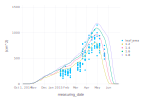

In [61]:
p = visualize(obs, :measuring_date, :leaf_area;
    xlim,
    ylim = (0,1500),
)
visualize!(p, Garlic.Model, :time, :green_leaf_area;
    config, stop, snap,
    group = :Leaf => :SG => [1.2, 1.4, 1.6, 1.8],
    kind  = :line,
)

#### Minimum Length of Longest Leaf

In [62]:
config[:Leaf][:minimum_length_of_longest_leaf]

90.0

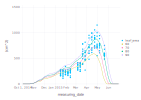

In [63]:
p = visualize(obs, :measuring_date, :leaf_area;
    xlim,
    ylim = (0,1500),
)
visualize!(p, Garlic.Model, :time, :green_leaf_area;
    config, stop, snap,
    group = :Leaf => :LM_min => [60, 70, 80, 90],
    kind  = :line,
)

#### Leaf Elongation Rate

In [64]:
config[:Leaf][:maximum_elongation_rate]

5.0

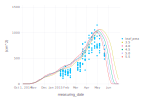

In [65]:
p = visualize(obs, :measuring_date, :leaf_area;
    xlim,
    ylim = (0,1500),
)
visualize!(p, Garlic.Model, :time, :green_leaf_area;
    config, stop, snap,
    group = :Leaf => :LER_max => [3.5, 4, 4.5, 5, 5.5],
    kind  = :line,
)

#### Planting Density

In [66]:
config[:Plant][:initial_planting_density]

55.5

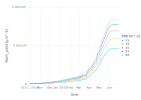

In [67]:
visualize(Garlic.Model, :time, :fresh_yield;
    config, stop, snap, xlim,
    group = :Density => :PD0 => [25, 35, 45, 55, 65],
    ylim  = (0,10000),
    kind  = :line,
)

### Application

Although the garlic model presented above is not as simple as other models we studied in the class, the Cropbox interface we use for interacting with the model remains mostly unchanged. Hope this gives you an idea how a large model can be composed of smaller pieces and used in the research.

Below is an application of the garlic model we've done recently. We used the model for testing a simple climate adaptation strategy, such as plating date shift, under climate change scenarios. More information is available with [Yun et al. (2022](https://doi.org/10.3389/fpls.2022.783810).

Note that actual code for doing **Ex 9.1.6** and **Ex 9.1.7** can be found at [GitHub](
https://github.com/cropbox/Garlic.jl/blob/main/src/examples/rcp.jl) as it gets a bit complex to run a large number of simulations and produce a collective plot out of them. We only provide the final results here.

#### Geography

Here are two locations in Korea. Gosan in Jeju island has warm climate that allows growing tons of garlic commercially. Chuncheon has cold winter not viable for growing this particular type of cultivar (Namdo) under current climate.

<img src="https://www.biorxiv.org/content/biorxiv/early/2021/11/04/2021.11.04.467009/F2.large.jpg" width="300">

#### Ex 9.1.6

Apply the model to assess climate change impact on a southern cultivar of garlic: Namdo in Jeju, Korea where they are currently grown.

#### Yield Projection (Gosan)

Here is the yield projection with a range of planting dates under current and future climate projection in Gosan, Jeju which is a region grows ND cultivar at commercial scale.

![](https://www.biorxiv.org/content/biorxiv/early/2021/11/04/2021.11.04.467009/F8.large.jpg)

#### Ex 9.1.7

Apply the model to evaluate climate adaptation options such as changing planting dates and moving cultivation to a northern location: Chuncheon, Korea.

#### Yield Projection (Chuncheon)

Here is the yield projection with a range of planting dates under current and future climate projection in Chuncheon, Gangwon where current climate is not favorable for growing ND cultivar.

![](https://www.biorxiv.org/content/biorxiv/early/2021/11/04/2021.11.04.467009/F9.large.jpg)

#### Optimal Planting Dates

Here is a plot for optimal planting dates estimated for each year under current and future climate projections in Gosan and Chuncheon.

![](https://www.biorxiv.org/content/biorxiv/early/2021/11/04/2021.11.04.467009/F10.large.jpg)

#### Ex 9.1.8

Add interpretation and discussion to your responses to all questions as appropriate.

### Ex 9.2

There will be a **bonus lab exercise** to explore 3D root structural modeling using Cropbox. With this, we will explore ways to use Cropbox outside the class JupyterHub environment using such tools as REPL, VSCode, and local JupyterLab. *You do not need to include this bonus part in your lab assignment.*

## Root Model (bonus)

Although Cropbox framework was originally designed for developing conventional process-based models with mostly static structure, we have a proof of concept application to show its capability towards functional-structural plant models (FSPM).

More specifically, dynamic generation of system instances during simulation thanks to `produce` variable allowed an implemenation of a root structure growth algorithm similar to [CRootBox](https://plant-root-soil-interactions-modelling.github.io/CRootBox/) model. Thus we named our package [CropRootBox.jl](https://github.com/cropbox/CropRootBox.jl).

In [68]:
using CropRootBox

### Configuration

Root system architecture in this example constists of three types of segments: primary root, first order lateral root, and second order lateral root. The number of initial primary roots is set by a parameter (`maxB`). As a segment grows, a new segment can be initiated and spawned depending on the transition table (`T`). Each segment type has its own set of parameters related to length (`lb` for basal zone, `la` for axial zone, `ln` for branching interval), elongation rate (`r`), branching angle (`θ`) and so on. Note that some parameter values are combined with standard deviation after `±` operator whose acutal value is decided on initialization. Random sampling of parameters is what gives more realistic root growth behavior for the model.

In [69]:
root_maize = @config(
    :RootArchitecture => :maxB => 5,
    :BaseRoot => :T => [
        # P F S
          0 1 0 ; # P
          0 0 1 ; # F
          0 0 0 ; # S
    ],
    :PrimaryRoot => (;
        lb    = 0.1 ± 0.01,
        la    = 18.0 ± 1.8,
        ln    = 0.6 ± 0.06,
        lmax  = 89.7 ± 7.4,
        r     = 6.0 ± 0.6,
        Δx    = 0.5,
        σ     = 10,
        θ     = 80 ± 8,
        N     = 1.5,
        a     = 0.04 ± 0.004,
        color = CropRootBox.RGBA(1, 0, 0, 1),
    ),
    :FirstOrderLateralRoot => (;
        lb    = 0.2 ± 0.04,
        la    = 0.4 ± 0.04,
        ln    = 0.4 ± 0.03,
        lmax  = 0.6 ± 1.6,
        r     = 2.0 ± 0.2,
        Δx    = 0.1,
        σ     = 20,
        θ     = 70 ± 15,
        N     = 1,
        a     = 0.03 ± 0.003,
        color = CropRootBox.RGBA(0, 1, 0, 1),
    ),
    :SecondOrderLateralRoot => (;
        lb    = 0,
        la    = 0.4 ± 0.02,
        ln    = 0,
        lmax  = 0.4,
        r     = 2.0 ± 0.2,
        Δx    = 0.1,
        σ     = 20,
        θ     = 70 ± 10,
        N     = 2,
        a     = 0.02 ± 0.002,
        color = CropRootBox.RGBA(0, 0, 1, 1),
    ),
)

Config for 5 systems:
  RootArchitecture
    maxB = 5
  BaseRoot
    T = [0 1 0; 0 0 1; 0 0 0]
  PrimaryRoot
    lb    = 0.1 ± 0.01
    la    = 18.0 ± 1.8
    ln    = 0.6 ± 0.06
    lmax  = 89.7 ± 7.4
    r     = 6.0 ± 0.6
    Δx    = 0.5
    σ     = 10
    θ     = 80 ± 8
    N     = 1.5
    a     = 0.04 ± 0.004
    color = RGBA{N0f8}(1.0,0.0,0.0,1.0)
  FirstOrderLateralRoot
    lb    = 0.2 ± 0.04
    la    = 0.4 ± 0.04
    ln    = 0.4 ± 0.03
    lmax  = 0.6 ± 1.6
    r     = 2.0 ± 0.2
    Δx    = 0.1
    σ     = 20
    θ     = 70 ± 15
    N     = 1
    a     = 0.03 ± 0.003
    color = RGBA{N0f8}(0.0,1.0,0.0,1.0)
  SecondOrderLateralRoot
    lb    = 0
    la    = 0.4 ± 0.02
    ln    = 0
    lmax  = 0.4
    r     = 2.0 ± 0.2
    Δx    = 0.1
    σ     = 20
    θ     = 70 ± 10
    N     = 2
    a     = 0.02 ± 0.002
    color = RGBA{N0f8}(0.0,0.0,1.0,1.0)

### Simulation

First we create an instance of pot (`Root.Pot`) which is a container holding our root system.

In [70]:
b = instance(CropRootBox.Pot)

Pot
  context = <Context>
  config = <Config>
  dist (distance) = <call>
  r1 (top_radius) = 10.0 cm
  r2 (bottom_radius) = 6.0 cm
  h (height) = 30.0 cm
  sq (square) = false

Then, an instance of root system (`Root.RootArchitecture`) is created with parameters for maize (`root_maize`). The instance of pot (`b`) just created above is supplied as an option. `seed` argument indicates a seed number for random number generator. By having a fixed seed number, we have same simulation results every time the model runs.

In [71]:
s = instance(CropRootBox.RootArchitecture;
    config  = root_maize,
    options = (; box = b),
    seed    = 0,
)

RootArchitecture
  context = <Context>
  config = <Config>
  box = <Pot>
  minB (minimum_number_of_basal_roots) = 1.0
  maxB (number_of_basal_roots) = 5.0
  RT0 (initial_transformation) = IdentityTransformation()
  roots = CropRootBox.var"##_PrimaryRoot#828"[]

Note that we explicitly create an instance of the model using `instance()` instead of `simulate()` which only gives an output of simulation. We need an instance later for 3D visualization.

In [72]:
r = simulate!(s; stop = 100u"d")

Progress: 100%[===========================] Time: 0:00:17 ( 7.12 ms/it)


2401×3 DataFrame
  Row │ time       minB     maxB
      │ Quantity…  Float64  Float64
──────┼─────────────────────────────
    1 │    0.0 hr      1.0      5.0
    2 │    1.0 hr      1.0      5.0
    3 │    2.0 hr      1.0      5.0
    4 │    3.0 hr      1.0      5.0
    5 │    4.0 hr      1.0      5.0
    6 │    5.0 hr      1.0      5.0
    7 │    6.0 hr      1.0      5.0
    8 │    7.0 hr      1.0      5.0
    9 │    8.0 hr      1.0      5.0
   10 │    9.0 hr      1.0      5.0
   11 │   10.0 hr      1.0      5.0
  ⋮   │     ⋮         ⋮        ⋮
 2392 │ 2391.0 hr      1.0      5.0
 2393 │ 2392.0 hr      1.0      5.0
 2394 │ 2393.0 hr      1.0      5.0
 2395 │ 2394.0 hr      1.0      5.0
 2396 │ 2395.0 hr      1.0      5.0
 2397 │ 2396.0 hr      1.0      5.0
 2398 │ 2397.0 hr      1.0      5.0
 2399 │ 2398.0 hr      1.0      5.0
 2400 │ 2399.0 hr      1.0      5.0
 2401 │ 2400.0 hr      1.0      5.0
                   2380 rows omitted

### Analysis

We can *gather* all root segments produced during simulation from the current instance of model.

In [73]:
L = gather!(s, CropRootBox.BaseRoot; callback = CropRootBox.gatherbaseroot!)

6715-element Vector{Any}:
 <PrimaryRoot>
 <PrimaryRoot>
 <PrimaryRoot>
 <PrimaryRoot>
 <PrimaryRoot>
 <PrimaryRoot>
 <PrimaryRoot>
 <PrimaryRoot>
 <PrimaryRoot>
 <PrimaryRoot>
 <PrimaryRoot>
 <PrimaryRoot>
 <PrimaryRoot>
 ⋮
 <FirstOrderLateralRoot>
 <FirstOrderLateralRoot>
 <SecondOrderLateralRoot>
 <SecondOrderLateralRoot>
 <SecondOrderLateralRoot>
 <SecondOrderLateralRoot>
 <FirstOrderLateralRoot>
 <FirstOrderLateralRoot>
 <FirstOrderLateralRoot>
 <FirstOrderLateralRoot>
 <FirstOrderLateralRoot>
 <FirstOrderLateralRoot>

Then, here is the total root length from this simluation.

In [74]:
[s.length' for s in L] |> sum

1030.2072062637315 cm

### Visualization

3D structure of the root system can be visualized via 3D rendering packages. However, it currently doesn't work on JupyterHub environment we use for the lab. I'll show you how it runs on my local computer.

In [75]:
using WGLMakie

In [76]:
scn = CropRootBox.render(s; resolution = (2000, 2000))

Due to an [issue](https://github.com/JuliaPlots/Makie.jl/issues/1396) in WGLMakie (as of 0.4.7), the rendered frame above may be confined in a cell with very small height. Right click on an empty area and try open a new window for the frame (in the case of Safari browser) to see it more clearly.